# Real-time Adaptive PID Control for DC Motor Speed Regulation using Neural Network-based Self-tuning

**Machine Learning (CS-5841/EE-5841) Project**  
*Mbadiwe S. Benyeogor, Mark-Anthony Agbanu, Kepha Barasa, and Joseph Alfred Sonne*


**Instructor: Professor Sujan Kumar Roy**


# Introduction
This software documentation describes the functionality of a real-time Artificial Neural Network (ANN)-tuned PID motor speed control system implemented in Python. The system uses a Proportional-Integral-Derivative (PID) controller initially, and after 20% of the total runtime, the ANN dynamically adjusts the PID gains for improved performance. The control loop is executed in real-time, interfacing with an Arduino via serial communication.

# System Overview
The system consists of:
- A PID controller for initial motor speed regulation.
- An ANN for self-tuning of PID gains after 20% of the runtime.
- A serial communication interface to receive speed measurements and send control signals.
- A CSV logging mechanism for data storage.
- Real-time visualization of system performance using Matplotlib.


# Experimental Setup

The experimental setup displayed in Figure 1 is essential for implementing and testing the Python code provided below. Each device in the setup is a critical component of the control loop, ensuring the system operates as intended. The experiment primarily investigates the performance of an ANN-enhanced PID control system, comparing it with that of a classical PID control algorithm. This approach evaluates the advantages of integrating machine learning into traditional control methods for improved system efficiency.

![Experimental Setup](Device2.png)

*Figure 1: Experimental setup showing the components of the real-time ANN-enabled PID motor speed control system.*

---

^1 The devices in the experimental setup are required for the Python code below to function correctly.




# Classical PID Control program without ANN-enabled Self-tuning:

Enter desired motor speed (RPM): 6000
Enter duration for PID control (seconds): 20
Time: 1.90s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 12612.75 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 2.93s | Desired: 6000.00 RPM | Measured: 4021.00 RPM | Error: 1979.00 RPM | PWM: 1168.65 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 3.98s | Desired: 6000.00 RPM | Measured: 5028.00 RPM | Error: 972.00 RPM | PWM: 1064.45 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 5.01s | Desired: 6000.00 RPM | Measured: 5045.00 RPM | Error: 955.00 RPM | PWM: 1532.25 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 6.04s | Desired: 6000.00 RPM | Measured: 5031.00 RPM | Error: 969.00 RPM | PWM: 1570.15 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 7.06s | Desired: 6000.00 RPM | Measured: 5028.00 RPM | Error: 972.00 RPM | PWM: 1569.45 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 8.11s | Desired: 6000.00 RPM | Measured: 5000.00 RPM | Error: 1000.00 RPM | PWM: 1626.75 | Kp: 1.6 | Ki: 0.05 | Kd: 0.5
Time: 9.14s | Desired: 6000.00 RPM | Meas

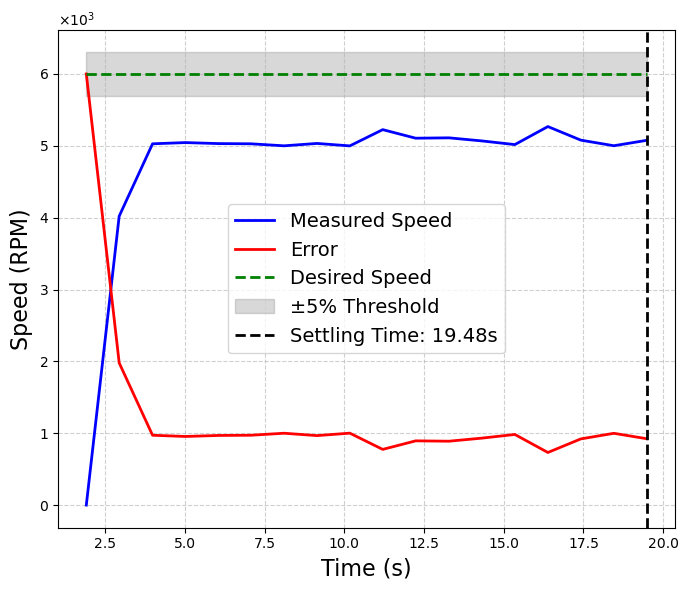

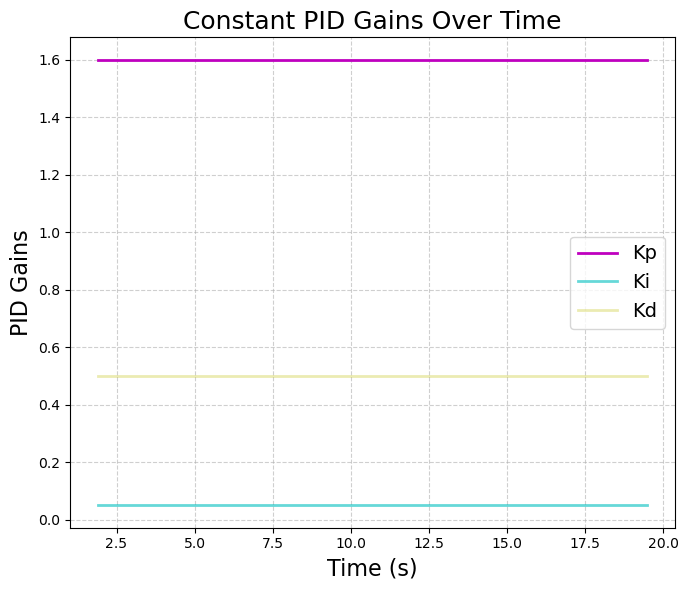

Data saved to PID_motor_data_20250404_213138.csv
Speed plot saved to PID_motor_plot_speed_20250404_213138.pdf
PID gains plot saved to PID_motor_plot_gains_20250404_213138.pdf


In [2]:
import serial
import time
import csv
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import ScalarFormatter

# PID Parameters (Tune as needed)
Kp = 1.6
Ki = 0.05
Kd = 0.5

# User Inputs
desired_speed = float(input("Enter desired motor speed (RPM): "))
runtime = float(input("Enter duration for PID control (seconds): "))

# Initialize Serial Communication (Update COM port if necessary)
ser = serial.Serial('COM3', 115200, timeout=0.2)  # Ensure COM port matches your system

# PID Variables
previous_error = 0
integral = 0

# Anti-Windup Limits
integral_min = -255
integral_max = 255

# Data Logging
times, speeds, errors, pwm_outputs = [], [], [], []
kp_values, ki_values, kd_values = [], [], []
start_time = time.time()

# Generate dynamic filenames with timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"PID_motor_data_{current_time}.csv"
pdf_filename_speed = f"PID_motor_plot_speed_{current_time}.pdf"
pdf_filename_gains = f"PID_motor_plot_gains_{current_time}.pdf"

# CSV File Setup
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Time (s)", "Desired Speed (RPM)", "Measured Speed (RPM)", "Error (RPM)", "PWM Output", "Kp", "Ki", "Kd"])  # CSV Header

def pid_control(measured_speed):
    """Compute PID control signal."""
    global previous_error, integral

    # PID computation
    error = desired_speed - measured_speed
    integral += error
    integral = max(min(integral, integral_max), integral_min)  # Anti-windup
    derivative = error - previous_error
    control_signal = (Kp * error) + (Ki * integral) + (Kd * derivative)
    previous_error = error

    return control_signal

# Main Control Loop
while time.time() - start_time < runtime:  # Run for user-defined duration
    response = ser.readline().decode().strip()
    if response:
        try:
            measured_speed = float(response)  # Measured speed in RPM
            elapsed_time = time.time() - start_time

            # Compute PID control output
            pwm_output = pid_control(measured_speed)
            ser.write(f"{pwm_output}\n".encode())  # Send PWM to Arduino

            # Store data
            times.append(elapsed_time)
            speeds.append(measured_speed)
            errors.append(desired_speed - measured_speed)
            pwm_outputs.append(pwm_output)
            kp_values.append(Kp)
            ki_values.append(Ki)
            kd_values.append(Kd)

            # Print output with current parameters
            print(f"Time: {elapsed_time:.2f}s | Desired: {desired_speed:.2f} RPM | "
                  f"Measured: {measured_speed:.2f} RPM | Error: {errors[-1]:.2f} RPM | "
                  f"PWM: {pwm_output} | Kp: {Kp} | Ki: {Ki} | Kd: {Kd}")

            # Save data to CSV
            with open(csv_filename, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([elapsed_time, desired_speed, measured_speed, errors[-1], pwm_output, Kp, Ki, Kd])

        except ValueError:
            print("Invalid data received.")

ser.close()

# Compute Settling Time (Ts)
settling_threshold = desired_speed * 0.05  # 5% threshold in RPM
Ts = next((t for t, e in zip(times, errors) if abs(e) <= settling_threshold), times[-1])

# Generate and Save Measured Speed & Error Plot
plt.figure(figsize=(7, 6))
plt.plot(times, speeds, label="Measured Speed", color="b", linewidth=2)
plt.plot(times, errors, label="Error", color="r", linewidth=2)
plt.plot(times, [desired_speed] * len(times), label="Desired Speed", color="g", linestyle="--", linewidth=2)

# Add shaded threshold region
threshold_lower = desired_speed * 0.95  # Lower bound of ±5% threshold
threshold_upper = desired_speed * 1.05  # Upper bound of ±5% threshold
plt.fill_between(times, threshold_lower, threshold_upper, color="gray", alpha=0.3, label="±5% Threshold")

# Add settling time marker
if Ts:
    plt.axvline(Ts, color="black", linestyle="--", linewidth=2, label=f"Settling Time: {Ts:.2f}s")
    #plt.text(Ts, desired_speed, f"  Ts = {Ts:.2f}s", fontsize=12, color="black", va="bottom")

# Add labels, title, and grid
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Speed (RPM)", fontsize=16)
#plt.title("Measured Speed and Error for PID Control without ANN", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)

# Y-axis scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((3, 3))  # Enforce scientific notation
plt.gca().yaxis.set_major_formatter(formatter)

# Add legend
plt.legend(fontsize=14)

# Save as PDF
plt.tight_layout()
plt.savefig(pdf_filename_speed, format="pdf")
plt.show()

# Generate and Save PID Gains Plot
plt.figure(figsize=(7, 6))
plt.plot(times, kp_values, label="Kp", color="m", linewidth=2)
plt.plot(times, ki_values, label="Ki", color="c", linewidth=2, alpha=0.6)
plt.plot(times, kd_values, label="Kd", color="y", linewidth=2, alpha=0.3)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("PID Gains", fontsize=16)
plt.title("Constant PID Gains Over Time", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)

# Save as PDF
plt.tight_layout()
plt.savefig(pdf_filename_gains, format="pdf")
plt.show()

# Final Report
print(f"Data saved to {csv_filename}")
print(f"Speed plot saved to {pdf_filename_speed}")
print(f"PID gains plot saved to {pdf_filename_gains}")


Performance Metrics:
Root Mean Square Error (RMSE): 1775.40 RPM
Mean Absolute Error (MAE): 1344.11 RPM
Steady-State Error (SSE): 1014.00 RPM
Maximum Speed: 5169.00 RPM
Overshoot: 0.00%
Settling Time (Ts): Not achieved within the runtime.


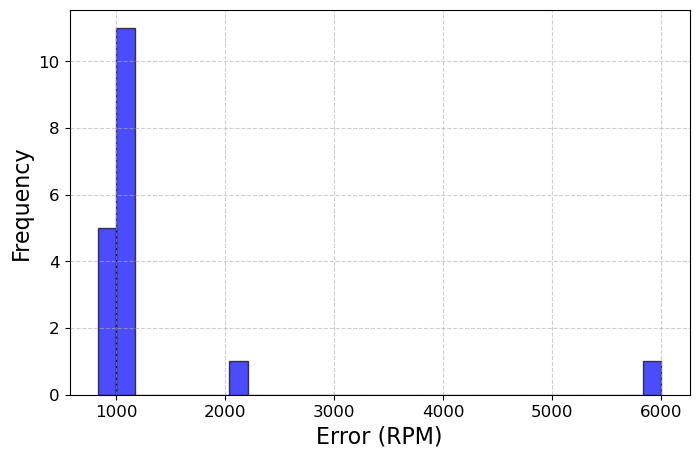

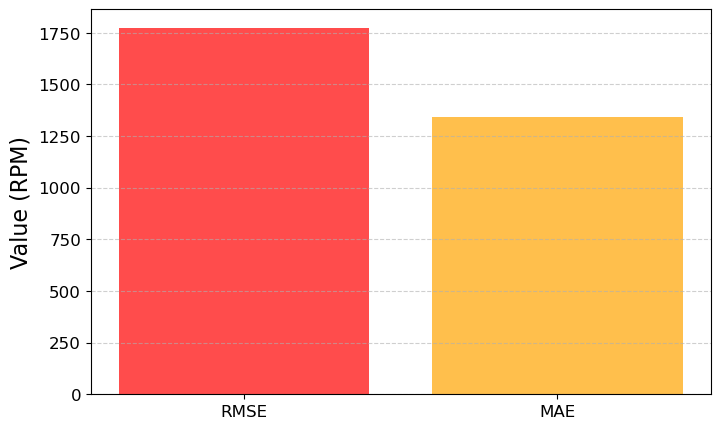

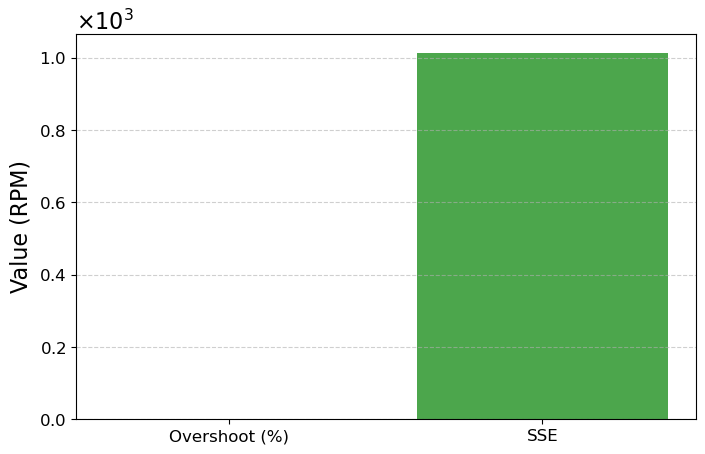

Graphs saved as Evaluation_No_ANN_20250404_210921.pdf


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

# Convert lists to NumPy arrays for performance calculations
time_stamps = np.array(times)  # Recorded time points
error = np.array(errors)
setpoints = np.array([desired_speed] * len(times))  # Setpoints stored as an array
speeds = np.array(speeds)

# Compute Performance Metrics
rmse = np.sqrt(np.mean(error ** 2))  # Root Mean Square Error
mae = np.mean(np.abs(error))  # Mean Absolute Error
SSE = error[-1]  # Last recorded steady-state error
max_speed = max(speeds)  # Maximum speed recorded
overshoot = max(0, ((max_speed - desired_speed) / desired_speed) * 100)  # Percentage overshoot

# Settling Time (Ts)
within_tolerance = np.abs(error) < (0.05 * desired_speed)  # Define ±5% tolerance band
Ts_index = np.argmax(within_tolerance) if np.any(within_tolerance) else -1
Ts = time_stamps[Ts_index] if Ts_index != -1 else None  # First time where error is within ±5%

# Print Summary of Performance Metrics
print("Performance Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} RPM")
print(f"Mean Absolute Error (MAE): {mae:.2f} RPM")
print(f"Steady-State Error (SSE): {SSE:.2f} RPM")
print(f"Maximum Speed: {max_speed:.2f} RPM")
print(f"Overshoot: {overshoot:.2f}%")
print(f"Settling Time (Ts): {Ts:.2f} seconds" if Ts else "Settling Time (Ts): Not achieved within the runtime.")

# Generate Performance Plots and Save as PDF
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
pdf_filename = f"Evaluation_No_ANN_{current_datetime}.pdf"  # Filename with tag

# 1. Histogram of Errors
plt.figure(figsize=(8, 5))
plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')
#plt.title("Histogram of Errors", fontsize=16)
plt.xlabel("Error (RPM)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")
plt.show()

# 2. RMSE & MAE Comparison
plt.figure(figsize=(8, 5))
plt.bar(["RMSE", "MAE"], [rmse, mae], color=['red', 'orange'], alpha=0.7)
#plt.title("RMSE & MAE Comparison", fontsize=16)
plt.ylabel("Value (RPM)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")
plt.show()

# 3. Overshoot & Steady-State Error
plt.figure(figsize=(8, 5))
plt.bar(["Overshoot (%)", "SSE"], [overshoot, SSE], color=['purple', 'green'], alpha=0.7)
#plt.title("Overshoot & Steady-State Error", fontsize=16)
plt.ylabel("Value (RPM)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Apply Scientific Notation for the Y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((3, 3))  # Enforce scientific notation
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")
plt.show()

print(f"Graphs saved as {pdf_filename}")


# Enhanced PID Control program with ANN-enabled Self-tuning:

Enter desired motor speed (RPM): 6000
Enter duration for PID control (seconds): 20
Time: 0.01s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6000.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.01s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6300.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.01s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6600.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.02s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6600.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.02s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6600.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.02s | Desired: 6000.00 RPM | Measured: 0.00 RPM | Error: 6000.00 RPM | PWM: 6600.0 | Kp: 1.000 | Ki: 0.050 | Kd: 0.500 | Loss: 0.000000
Time: 0.02s | Desired: 6000.00 RPM | Measured: 0.00 R

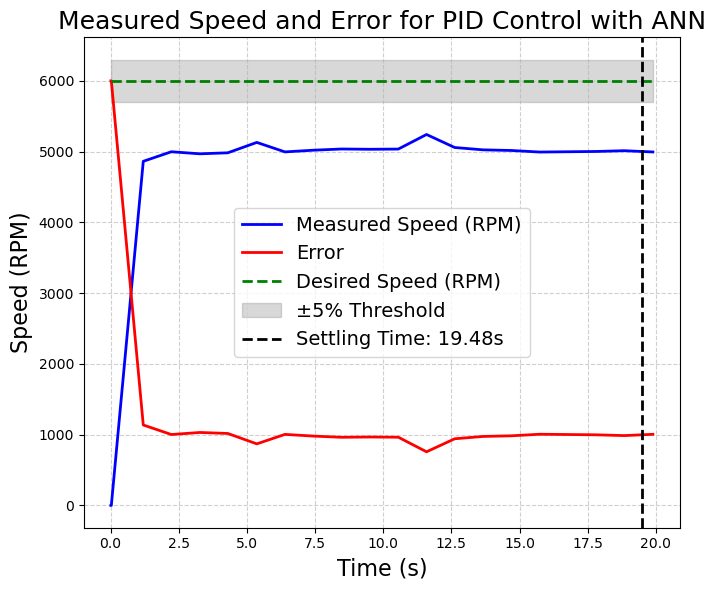

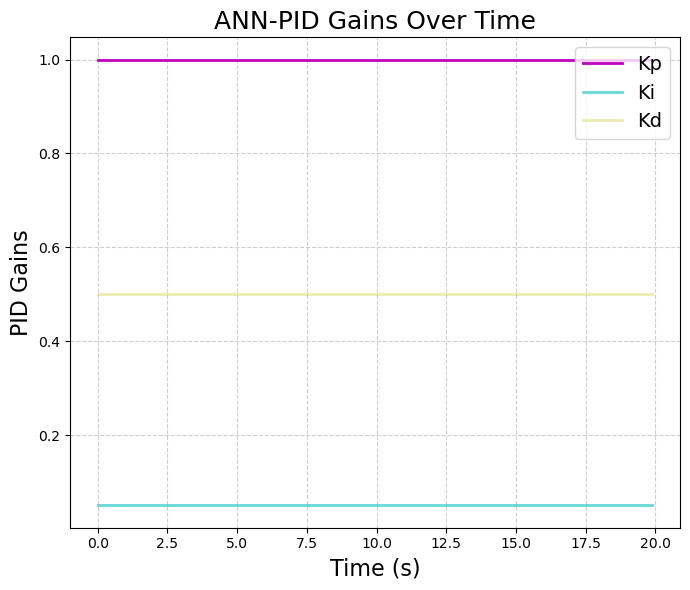

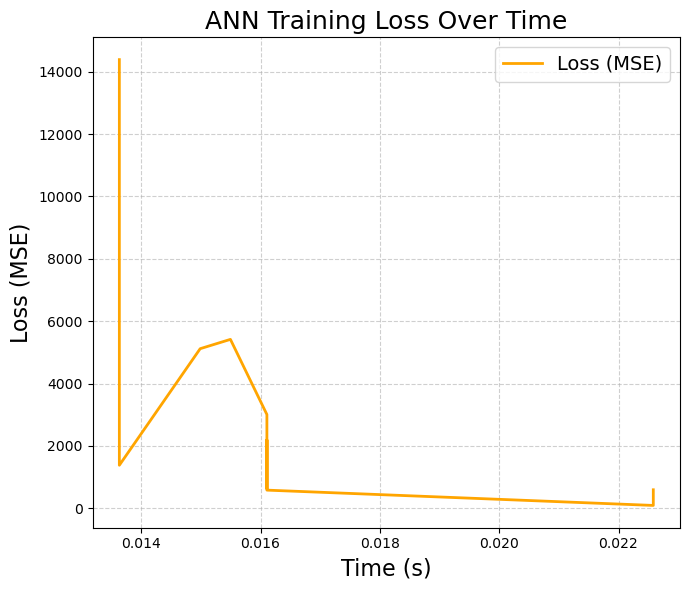

Data saved to motor_speed_data_ANN_20250404_213405.csv
Measured Speed plot saved to motor_speed_plot_speed_ANN_20250404_213405.pdf
PID Gains plot saved to motor_speed_plot_gains_ANN_20250404_213405.pdf
Loss plot saved to motor_speed_plot_loss_ANN_20250404_213405.pdf


In [3]:
import serial
import time
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

# Initialize Serial Communication (Update COM Port)
ser = serial.Serial('COM3', 115200, timeout=0.1)

# PID Initial Parameters
Kp, Ki, Kd = 1.0, 0.05, 0.5
desired_speed = float(input("Enter desired motor speed (RPM): "))
runtime = float(input("Enter duration for PID control (seconds): "))
ann_start_time = runtime * 0.2  # ANN starts optimizing after 20% of runtime

# Define ANN Model (PyTorch)
class PIDANN(nn.Module):
    def __init__(self):
        super(PIDANN, self).__init__()
        self.fc1 = nn.Linear(5, 16)  # 5 Inputs -> 16 Neurons
        self.fc2 = nn.Linear(16, 16)  # Hidden layer
        self.fc3 = nn.Linear(16, 3)  # 3 Outputs (Kp, Ki, Kd)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (raw values)
        return x

# Initialize ANN Model
model = PIDANN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Data Logging
times, speeds, errors, pwm_outputs = [], [], [], []
kp_values, ki_values, kd_values, loss_values = [], [], [], []
start_time = time.time()
history = []  # Training Buffer
history_size = int(runtime * 0.1)  # Keep last nth data points for ANN training--10% size of run time

# Generate dynamic filenames for CSV and PDF
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"motor_speed_data_ANN_{current_datetime}.csv"
pdf_filename_speed = f"motor_speed_plot_speed_ANN_{current_datetime}.pdf"
pdf_filename_gains = f"motor_speed_plot_gains_ANN_{current_datetime}.pdf"
pdf_filename_loss = f"motor_speed_plot_loss_ANN_{current_datetime}.pdf"

# CSV File Setup
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Time (s)", "Desired Speed (RPM)", "Measured Speed (RPM)", "Error (RPM)", 
                     "PWM Output", "Kp", "Ki", "Kd", "Loss"])  # CSV Header

def pid_control(measured_speed, elapsed_time):
    """Compute PID control signal."""
    global Kp, Ki, Kd, history

    error = desired_speed - measured_speed
    delta_error = error - errors[-1] if errors else 0
    control_signal = (Kp * error) + (Ki * sum(errors[-history_size:])) + (Kd * delta_error)

    # ANN Optimization only after 20% runtime
    if elapsed_time >= ann_start_time and len(history) > 10:
        inputs = np.array([len(errors), desired_speed, measured_speed, error, control_signal], dtype=np.float32)
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

        with torch.no_grad():
            output_tensor = model(inputs_tensor)

        Kp, Ki, Kd = output_tensor.numpy()

        # Apply constraints
        Kp = max(0.0, min(Kp, 50.0))
        Ki = max(0.0, min(Ki, 25.0))
        Kd = max(0.0, min(Kd, 25.0))

    # Train the ANN Online only after given runtime (e.g., 20% runtime)
    if elapsed_time >= ann_start_time:
        history.append([len(errors), desired_speed, measured_speed, error, control_signal, Kp, Ki, Kd])
        if len(history) > history_size:
            history.pop(0)

        x_train = torch.tensor([h[:-3] for h in history], dtype=torch.float32)
        y_train = torch.tensor([h[-3:] for h in history], dtype=torch.float32)

        optimizer.zero_grad()
        prediction = model(x_train)
        loss = loss_function(prediction, y_train)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        loss_values.append(loss_value)
    else:
        loss_value = 0  # Before 20% runtime, no ANN training

    return control_signal, loss_value

# Main Control Loop
while time.time() - start_time < runtime:
    response = ser.readline().decode().strip()
    if response:
        measured_speed = float(response)  # Measured speed in RPM
        elapsed_time = time.time() - start_time
        
        # Compute PID output with ANN tuning only after 20% runtime
        pwm_output, loss_value = pid_control(measured_speed, elapsed_time)
        ser.write(f"{pwm_output}\n".encode())  # Send PWM to Arduino

        # Store Data
        times.append(elapsed_time)
        speeds.append(measured_speed)
        errors.append(desired_speed - measured_speed)
        pwm_outputs.append(pwm_output)
        kp_values.append(Kp)
        ki_values.append(Ki)
        kd_values.append(Kd)

        # Save to CSV
        with open(csv_filename, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([elapsed_time, desired_speed, measured_speed, errors[-1], pwm_output, 
                             Kp, Ki, Kd, loss_value])

        # Print data in real-time
        print(f"Time: {elapsed_time:.2f}s | Desired: {desired_speed:.2f} RPM | Measured: {measured_speed:.2f} RPM | "
              f"Error: {errors[-1]:.2f} RPM | PWM: {pwm_output} | Kp: {Kp:.3f} | Ki: {Ki:.3f} | "
              f"Kd: {Kd:.3f} | Loss: {loss_value:.6f}")

ser.close()

# Generate Measured Speed & Error Plot
plt.figure(figsize=(7, 6))
plt.plot(times, speeds, label="Measured Speed (RPM)", color="b", linewidth=2)
plt.plot(times, errors, label="Error", color="r", linewidth=2)
plt.plot(times, [desired_speed] * len(times), label="Desired Speed (RPM)", color="g", linestyle="--", linewidth=2)

# Add shaded threshold region
threshold_lower = desired_speed * 0.95  # Lower bound of ±5% threshold
threshold_upper = desired_speed * 1.05  # Upper bound of ±5% threshold
plt.fill_between(times, threshold_lower, threshold_upper, color="gray", alpha=0.3, label="±5% Threshold")

# Add settling time marker
if Ts:
    plt.axvline(Ts, color="black", linestyle="--", linewidth=2, label=f"Settling Time: {Ts:.2f}s")
    #plt.text(Ts, desired_speed, f"  Ts = {Ts:.2f}s", fontsize=12, color="black", va="bottom")

# Add legend
plt.legend(fontsize=14)

# Add labels, title, and grid
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Speed (RPM)", fontsize=16)
plt.title("Measured Speed and Error for PID Control with ANN", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)

# Save plot
plt.tight_layout()
plt.savefig(pdf_filename_speed, format="pdf")
plt.show()

# Generate PID Gains Plot
plt.figure(figsize=(7, 6))
plt.plot(times, kp_values, label="Kp", color="m", linewidth=2)
plt.plot(times, ki_values, label="Ki", color="c", linewidth=2, alpha=0.6)
plt.plot(times, kd_values, label="Kd", color="y", linewidth=2, alpha=0.3)

# Add legend
plt.legend(fontsize=14)

# Add labels, title, and grid
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("PID Gains", fontsize=16)
plt.title("ANN-PID Gains Over Time", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)

# Save plot
plt.tight_layout()
plt.savefig(pdf_filename_gains, format="pdf")
plt.show()

# Generate Loss Plot
plt.figure(figsize=(7, 6))
plt.plot(times[:len(loss_values)], loss_values, label="Loss (MSE)", color="orange", linewidth=2)

# Add legend
plt.legend(fontsize=14)

# Add labels, title, and grid
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Loss (MSE)", fontsize=16)
plt.title("ANN Training Loss Over Time", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)

# Save plot
plt.tight_layout()
plt.savefig(pdf_filename_loss, format="pdf")
plt.show()

# Final Outputs
print(f"Data saved to {csv_filename}")
print(f"Measured Speed plot saved to {pdf_filename_speed}")
print(f"PID Gains plot saved to {pdf_filename_gains}")
print(f"Loss plot saved to {pdf_filename_loss}")


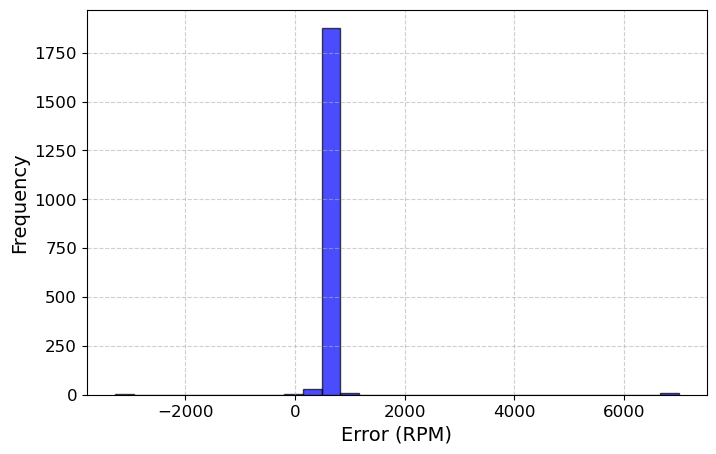

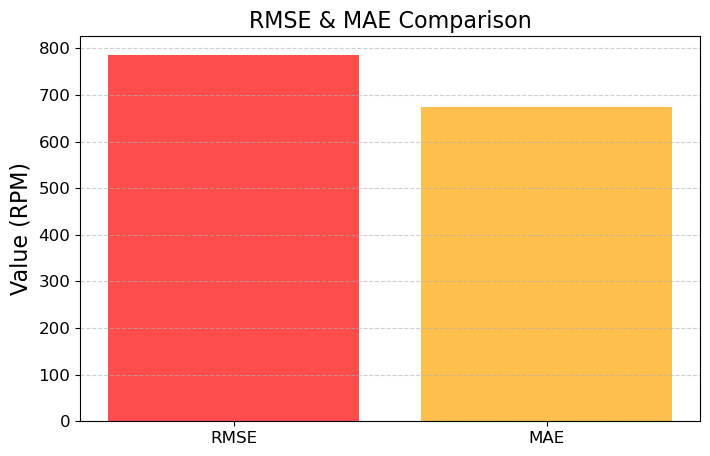

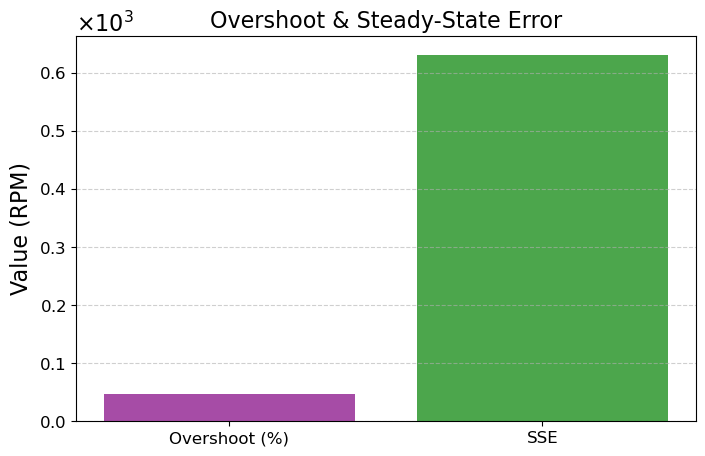

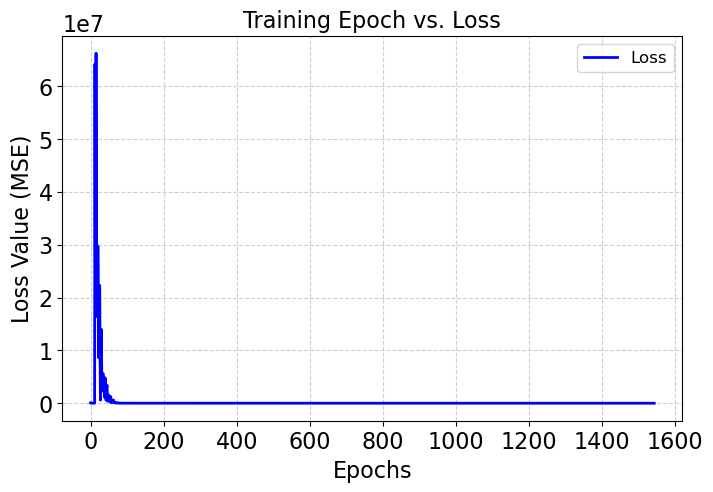


 **Statistical Evaluation:**
RMSE: 786.61 RPM
MAE: 674.44 RPM
Settling Time (Ts): 1.15 s
Steady-State Error (SSE): 631.00 RPM
Overshoot: 46.90%

Plots saved in file: Evaluation_ANN_20250315_220804.pdf


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

# Convert lists to NumPy arrays for performance calculations
time_stamps = np.array(times)  # Recorded time points
error = np.array(errors)
setpoints = np.array([desired_speed] * len(times))  # Setpoints stored as an array
speeds = np.array(speeds)

# Handle missing `loss_values`
if "loss_values" in globals() and len(loss_values) > 0:
    training_epochs = np.array(range(len(loss_values)))  # Training epochs for ANN
    loss_values = np.array(loss_values)
else:
    training_epochs = np.array([])  # Empty array if no loss data is available
    loss_values = np.array([])

# Compute Performance Metrics
rmse = np.sqrt(np.mean(error ** 2))
mae = np.mean(np.abs(error))
SSE = error[-1]  # Last recorded error
max_speed = max(speeds)
overshoot = max(0, ((max_speed - desired_speed) / desired_speed) * 100)

# Settling Time (Ts)
within_tolerance = np.abs(error) < (0.05 * desired_speed)  # Within ±5% of setpoint
Ts_index = np.argmax(within_tolerance) if np.any(within_tolerance) else -1
Ts = time_stamps[Ts_index] if Ts_index != -1 else None  # First time where error is within ±5%

# Generate Performance Plots and Save as PDF
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
pdf_filename = f"Evaluation_ANN_{current_datetime}.pdf"  # Filename with ANN tag

# 1. Histogram of Errors
plt.figure(figsize=(8, 5))
plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')
#plt.title("Histogram of Errors", fontsize=16)
plt.xlabel("Error (RPM)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")  # Save to PDF
plt.show()

# 2. RMSE & MAE Comparison
plt.figure(figsize=(8, 5))
plt.bar(["RMSE", "MAE"], [rmse, mae], color=['red', 'orange'], alpha=0.7)
plt.title("RMSE & MAE Comparison", fontsize=16)
plt.ylabel("Value (RPM)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")  # Save to PDF
plt.show()

# 3. Overshoot & Steady-State Error
plt.figure(figsize=(8, 5))
plt.bar(["Overshoot (%)", "SSE"], [overshoot, SSE], color=['purple', 'green'], alpha=0.7)
plt.title("Overshoot & Steady-State Error", fontsize=16)
plt.ylabel("Value (RPM)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
# Format Y-axis to use scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((3, 3))  # Enforce scientific notation
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")  # Save to PDF
plt.show()

# 4. ANN Loss Plot (if available)
if loss_values.size > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(training_epochs, loss_values, label="Loss", color="b", linewidth=2)
    plt.title("Training Epoch vs. Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss Value (MSE)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")  # Save to PDF
    plt.show()

# Print Statistical Summary
print("\n **Statistical Evaluation:**")
print(f"RMSE: {rmse:.2f} RPM")
print(f"MAE: {mae:.2f} RPM")
print(f"Settling Time (Ts): {Ts:.2f} s" if Ts is not None else " Settling Time Not Reached")
print(f"Steady-State Error (SSE): {SSE:.2f} RPM")
print(f"Overshoot: {overshoot:.2f}%")
print(f"\nPlots saved in file: {pdf_filename}")


# Arduino Code Description

The Arduino code (given below) is designed to control a DC motor using an Arduino microcontroller. The microcontroller powers the DC motor through a pulse-width modulation (PWM) driver. The code uses an shaft encoder to measure the motor's speed and a servo object to apply control. Real-time speed updates are sent to a connected Python script via serial communication, while PWM reference values received from the Python script are used to dynamically control the motor's speed. Encoder pulses are tracked using interrupts to ensure accurate speed measurements, creating a seamless integration between hardware and software for efficient motor control.

# The Arduino Code

```cpp
#include <Servo.h>  // Include the Servo library

Servo myservo;  // Servo object for motor control

// Encoder tracking
volatile unsigned int counter = 0;
unsigned long lastTime = 0;
const long interval = 1000;  // Speed update every 1 second

int speedValue = 0;  // Measured speed

void setup() {
    myservo.attach(9);  // Connect servo/motor control to pin 9
    Serial.begin(115200);  // Set serial baud rate

    pinMode(2, INPUT_PULLUP);  // Encoder input
    attachInterrupt(digitalPinToInterrupt(2), countPulses, RISING);  // Interrupt for encoder
}

void loop() {
    // Send speed to Python every second
    if (millis() - lastTime >= interval) {
        lastTime = millis();
        speedValue = map(counter, 0, 400, 0, 100);  // Convert pulses per second to speed in RPM
        Serial.println(speedValue);  // Send the speed to Python
        counter = 0;  // Reset counter
    }

    // Read PWM value from Python
    if (Serial.available()) {
        int pwmValue = Serial.parseInt();
        pwmValue = map(pwmValue, 30000, 0, 120, 140);  // Map PWM range
        myservo.write(pwmValue);  // Apply control
        delay(50);
    }
}

// Interrupt function to count encoder pulses
void countPulses() {
    counter++;
}
```


# Preliminary Result

The ANN-tuned PID controller outperforms the classical PID, achieving lower steady-state error and better adherence to the desired speed. Moreover, ongoing investigations are addressing the electrical and mechanical issues causing drift and undesirable step response, which reduces the systems performance.
